# Task 2: Fully Convolutional Network (FCN)

by Dechathon Niamsa-ard [st126235]

Implement an FCN for semantic segmentation, train it on a small dataset, and analyze how architectural and training choices affect performance.

**Instructions:**

**Dataset**:
- Use a subset of Pascal VOC, COCO, or a small custom dataset (10–20 images for quick runs).
- Split into train/test.
- Preprocess (resize, normalize, and convert masks to class indices).

**Model Implementation**:
- Implement FCN-8s with skip connections from pool3 and pool4.
- Use pretrained ResNet50 (remove final FC layers) as a backbone
- Upsampling Method: 1) transpose convolution vs 2) bilinear interpolation.

**Training**
- Loss: CrossEntropyLoss
- Optimizer: Adam or SGD
- Metrics: Mean IoU, pixel accuracy
- Train for 20 epochs (or until convergence).
- Log training curves.

**Deliverable:**

- Jupyter notebook with clear code and comments.
- Visualization of segmentation results (min. 3 test images).
- Table comparing transpose convolution vs bilinear interpolation.
- Summarize with visuals and short analysis.


## Import Libraries and Setup

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Dataset Preparation

**Note:** This notebook uses the local Pascal VOC dataset from the `datasets/task_2/` directory in the workspace.

**Dataset Source:** [Pascal VOC 2012 Dataset](https://www.kaggle.com/datasets/gopalbhattrai/pascal-vot-2012-dataset)

In [3]:
# Dataset path configuration
import os

workspace_path = os.getcwd()
print(f"Workspace directory: {workspace_path}")

# Try different possible dataset paths
possible_paths = [
    os.path.join(workspace_path, "datasets", "task_2", "VOC2012_train_val", "VOC2012_train_val")
]

path = None
for p in possible_paths:
    if os.path.exists(p) and os.path.exists(os.path.join(p, "JPEGImages")):
        path = p
        break

if path is None:
    raise FileNotFoundError("Pascal VOC dataset not found. Please ensure the dataset is in datasets/task_2/")

print(f"Dataset path: {path}")
print(f"✓ Dataset found successfully")

Workspace directory: c:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment3
Dataset path: c:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment3\datasets\task_2\VOC2012_train_val\VOC2012_train_val
✓ Dataset found successfully


In [4]:
# Configure dataset directories
images_dir = os.path.join(path, 'JPEGImages')
masks_dir = os.path.join(path, 'SegmentationClass')

# Validate dataset structure
for dir_path, dir_name in [(images_dir, 'Images'), (masks_dir, 'Masks')]:
    if not os.path.exists(dir_path):
        available_dirs = os.listdir(path) if os.path.exists(path) else []
        raise FileNotFoundError(f"{dir_name} directory not found: {dir_path}\nAvailable: {available_dirs}")

print(f"Images: {images_dir}")
print(f"Masks: {masks_dir}")

# Count dataset files
image_files = [f for f in os.listdir(images_dir) if f.lower().endswith('.jpg')]
mask_files = [f for f in os.listdir(masks_dir) if f.lower().endswith('.png')]

print(f"Total images: {len(image_files)}")
print(f"Total masks: {len(mask_files)}")
print("Dataset validation complete")

Images: c:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment3\datasets\task_2\VOC2012_train_val\VOC2012_train_val\JPEGImages
Masks: c:\Users\USER\Documents\Dechathon_N\AIT\Computer Vision\AIT-Computer-Vision-Assignment3\datasets\task_2\VOC2012_train_val\VOC2012_train_val\SegmentationClass
Total images: 17125
Total masks: 2913
Dataset validation complete


In [5]:
# Image selection and dataset splitting
import random
random.seed(42)

# Validate and collect valid image-mask pairs
all_images = [f for f in os.listdir(images_dir) if f.lower().endswith('.jpg')]

if not all_images:
    raise ValueError(f"No JPEG images found in {images_dir}")

valid_pairs = []
for img_file in all_images:
    mask_file = img_file.replace('.jpg', '.png')
    if os.path.exists(os.path.join(masks_dir, mask_file)):
        valid_pairs.append(img_file)

print(f"Found {len(all_images)} images, {len(valid_pairs)} with corresponding masks")

if len(valid_pairs) < 10:
    raise ValueError(f"Insufficient valid pairs ({len(valid_pairs)}). Need at least 10 for training.")

# Select training subset (up to 100 images)
max_samples = min(1000, len(valid_pairs))
selected_images = random.sample(valid_pairs, max_samples)

# Train/test split (80/20)
split_idx = max(1, int(0.8 * len(selected_images)))
train_images = selected_images[:split_idx]
test_images = selected_images[split_idx:]

print(f"Dataset split:")
print(f"  Total selected: {len(selected_images)}")
print(f"  Training: {len(train_images)}")
print(f"  Testing: {len(test_images)}")
print(f"  Sample files: {selected_images[:3]}")

Found 17125 images, 2913 with corresponding masks
Dataset split:
  Total selected: 1000
  Training: 800
  Testing: 200
  Sample files: ['2011_000658.jpg', '2007_007355.jpg', '2007_001698.jpg']


In [6]:
# Pascal VOC color map for visualization
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
               'diningtable', 'dog', 'horse', 'motorbike', 'person',
               'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

# Create colormap dictionary
colormap2label = np.zeros(256 ** 3, dtype=np.uint8)
for i, colormap in enumerate(VOC_COLORMAP):
    colormap2label[(colormap[0] * 256 + colormap[1]) * 256 + colormap[2]] = i

def voc_label_indices(colormap):
    """Convert RGB mask to class indices"""
    colormap = np.array(colormap).astype(np.int32)
    idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 + colormap[:, :, 2])
    return colormap2label[idx]

In [7]:
class VOCSegmentationDataset(Dataset):
    """Pascal VOC Dataset for semantic segmentation."""
    
    def __init__(self, images_dir, masks_dir, image_list, target_size=(256, 256)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_list = image_list
        self.target_size = target_size
        
        # ImageNet normalization parameters
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )
        
        # Validate all files exist
        self._validate_files()
    
    def _validate_files(self):
        """Validate that all image-mask pairs exist."""
        missing_files = []
        for img_name in self.image_list:
            img_path = os.path.join(self.images_dir, img_name)
            mask_path = os.path.join(self.masks_dir, img_name.replace('.jpg', '.png'))
            
            if not os.path.exists(img_path):
                missing_files.append(f"Image: {img_path}")
            if not os.path.exists(mask_path):
                missing_files.append(f"Mask: {mask_path}")
        
        if missing_files:
            raise FileNotFoundError(f"Missing files: {missing_files[:5]}...")
    
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.images_dir, img_name)
        mask_path = os.path.join(self.masks_dir, img_name.replace('.jpg', '.png'))
        
        try:
            # Load and preprocess image
            image = Image.open(img_path).convert('RGB')
            mask = Image.open(mask_path).convert('RGB')
            
            # Resize with appropriate interpolation
            image = image.resize(self.target_size, Image.BILINEAR)
            mask = mask.resize(self.target_size, Image.NEAREST)
            
            # Convert to arrays
            image_array = np.array(image, dtype=np.float32)
            mask_array = np.array(mask)
            
            # Convert mask to class indices
            mask_indices = voc_label_indices(mask_array)
            
            # Convert to tensors
            image_tensor = torch.from_numpy(image_array).permute(2, 0, 1) / 255.0
            mask_tensor = torch.from_numpy(mask_indices).long()
            
            # Normalize image
            image_tensor = self.normalize(image_tensor)
            
            return image_tensor, mask_tensor
            
        except Exception as e:
            raise RuntimeError(f"Error loading {img_name}: {e}")

print("VOC Dataset class ready")

VOC Dataset class ready


In [8]:
# Create datasets and data loaders
train_dataset = VOCSegmentationDataset(images_dir, masks_dir, train_images)
test_dataset = VOCSegmentationDataset(images_dir, masks_dir, test_images)

train_loader = DataLoader(
    train_dataset, 
    batch_size=2, 
    shuffle=True, 
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True if torch.cuda.is_available() else False
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=2, 
    shuffle=False, 
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Dataset loaded:")
print(f"  Training: {len(train_dataset)} samples")
print(f"  Testing: {len(test_dataset)} samples")

# Validate dataset loading
try:
    sample_img, sample_mask = train_dataset[0]
    print(f"Sample validation:")
    print(f"  Image shape: {sample_img.shape}")
    print(f"  Mask shape: {sample_mask.shape}")
    print(f"  Classes in sample: {torch.unique(sample_mask).tolist()}")
except Exception as e:
    print(f"Dataset loading error: {e}")

Dataset loaded:
  Training: 800 samples
  Testing: 200 samples
Sample validation:
  Image shape: torch.Size([3, 256, 256])
  Mask shape: torch.Size([256, 256])
  Classes in sample: [0, 7]
  Classes in sample: [0, 7]


## Model Implementation

In [9]:
class FCN8s(nn.Module):
    """
    Fully Convolutional Network (8s) for semantic segmentation.
    Uses ResNet50 as backbone with skip connections from pool3 and pool4.
    Supports both transpose convolution and bilinear interpolation for upsampling.
    """
    
    def __init__(self, num_classes=21, upsampling='transpose'):
        super(FCN8s, self).__init__()
        self.num_classes = num_classes
        self.upsampling = upsampling
        
        # Load pretrained ResNet50 and extract feature layers
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        
        # Extract different levels of features for skip connections
        # pool3: after layer2 (512 channels, 1/8 resolution)
        # pool4: after layer3 (1024 channels, 1/16 resolution)  
        # pool5: after layer4 (2048 channels, 1/32 resolution)
        
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1  # 1/4 resolution, 256 channels
        self.layer2 = resnet.layer2  # 1/8 resolution, 512 channels (pool3)
        self.layer3 = resnet.layer3  # 1/16 resolution, 1024 channels (pool4)
        self.layer4 = resnet.layer4  # 1/32 resolution, 2048 channels (pool5)
        
        # Classifier heads for different scales
        self.classifier_pool5 = nn.Conv2d(2048, num_classes, kernel_size=1)  # 1/32
        self.classifier_pool4 = nn.Conv2d(1024, num_classes, kernel_size=1)  # 1/16
        self.classifier_pool3 = nn.Conv2d(512, num_classes, kernel_size=1)   # 1/8
        
        # Upsampling layers for FCN-8s
        if upsampling == 'transpose':
            # 2x upsampling from pool5 to pool4 resolution
            self.upsample_pool5 = nn.ConvTranspose2d(
                num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False
            )
            # 2x upsampling from fused pool4 to pool3 resolution
            self.upsample_pool4 = nn.ConvTranspose2d(
                num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False
            )
            # 8x upsampling from fused pool3 to original resolution
            self.upsample_final = nn.ConvTranspose2d(
                num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False
            )
            
            # Initialize with bilinear weights
            self._init_transpose_weights()
        else:  # bilinear interpolation
            self.upsample_2x = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
            self.upsample_8x = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=False)
    
    def _init_transpose_weights(self):
        """Initialize transpose convolution layers with bilinear weights"""
        def init_layer(layer):
            kernel_size = layer.kernel_size[0]
            stride = layer.stride[0]
            
            # Create bilinear kernel
            factor = (kernel_size + 1) // 2
            if kernel_size % 2 == 1:
                center = factor - 1
            else:
                center = factor - 0.5
            
            og = np.ogrid[:kernel_size, :kernel_size]
            filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
            weight = np.zeros((self.num_classes, self.num_classes, kernel_size, kernel_size))
            
            for i in range(self.num_classes):
                weight[i, i, :, :] = filt
            
            layer.weight.data.copy_(torch.from_numpy(weight))
        
        # Initialize all transpose convolution layers
        init_layer(self.upsample_pool5)
        init_layer(self.upsample_pool4)
        init_layer(self.upsample_final)
    
    def forward(self, x):
        # Save input size for final resize
        input_size = x.shape[2:]
        
        # Extract multi-scale features
        x = self.layer0(x)     # 1/4 resolution
        x = self.layer1(x)     # 1/4 resolution, 256 channels
        pool3 = self.layer2(x) # 1/8 resolution, 512 channels
        pool4 = self.layer3(pool3) # 1/16 resolution, 1024 channels
        pool5 = self.layer4(pool4) # 1/32 resolution, 2048 channels
        
        # Apply classifiers to each scale
        score_pool5 = self.classifier_pool5(pool5)  # 1/32 resolution
        score_pool4 = self.classifier_pool4(pool4)  # 1/16 resolution
        score_pool3 = self.classifier_pool3(pool3)  # 1/8 resolution
        
        if self.upsampling == 'transpose':
            # FCN-8s with transpose convolutions
            # Upsample pool5 by 2x and fuse with pool4
            upscore_pool5 = self.upsample_pool5(score_pool5)
            # Ensure size compatibility for addition
            if upscore_pool5.shape[2:] != score_pool4.shape[2:]:
                upscore_pool5 = nn.functional.interpolate(
                    upscore_pool5, size=score_pool4.shape[2:], mode='bilinear', align_corners=False
                )
            fuse_pool4 = upscore_pool5 + score_pool4
            
            # Upsample fused pool4 by 2x and fuse with pool3
            upscore_pool4 = self.upsample_pool4(fuse_pool4)
            if upscore_pool4.shape[2:] != score_pool3.shape[2:]:
                upscore_pool4 = nn.functional.interpolate(
                    upscore_pool4, size=score_pool3.shape[2:], mode='bilinear', align_corners=False
                )
            fuse_pool3 = upscore_pool4 + score_pool3
            
            # Final 8x upsampling to original resolution
            output = self.upsample_final(fuse_pool3)
            
        else:  # bilinear interpolation
            # FCN-8s with bilinear interpolation
            # Upsample pool5 by 2x and fuse with pool4
            upscore_pool5 = self.upsample_2x(score_pool5)
            if upscore_pool5.shape[2:] != score_pool4.shape[2:]:
                upscore_pool5 = nn.functional.interpolate(
                    upscore_pool5, size=score_pool4.shape[2:], mode='bilinear', align_corners=False
                )
            fuse_pool4 = upscore_pool5 + score_pool4
            
            # Upsample fused pool4 by 2x and fuse with pool3
            upscore_pool4 = self.upsample_2x(fuse_pool4)
            if upscore_pool4.shape[2:] != score_pool3.shape[2:]:
                upscore_pool4 = nn.functional.interpolate(
                    upscore_pool4, size=score_pool3.shape[2:], mode='bilinear', align_corners=False
                )
            fuse_pool3 = upscore_pool4 + score_pool3
            
            # Final 8x upsampling to original resolution
            output = self.upsample_8x(fuse_pool3)
        
        # Ensure exact size match with input
        if output.shape[2:] != input_size:
            output = nn.functional.interpolate(output, size=input_size, mode='bilinear', align_corners=False)
        
        return output

print("FCN8s model class implemented successfully")

FCN8s model class implemented successfully


## Training and Evaluation Functions

In [10]:
def calculate_iou(pred, target, num_classes=21):
    """Calculate mean Intersection over Union (IoU)"""
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    for cls in range(num_classes):
        pred_cls = pred == cls
        target_cls = target == cls
        
        if target_cls.long().sum().item() == 0:
            # If class is not present in ground truth, skip
            continue
            
        intersection = (pred_cls & target_cls).long().sum().item()
        union = (pred_cls | target_cls).long().sum().item()
        
        if union == 0:
            iou = 1.0  # Perfect score when both are empty
        else:
            iou = intersection / union
        ious.append(iou)
    
    return np.mean(ious) if ious else 0.0

def calculate_pixel_accuracy(pred, target):
    """Calculate pixel accuracy"""
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total

def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    total_accuracy = 0.0
    num_batches = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for images, masks in progress_bar:
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        _, predicted = torch.max(outputs, 1)
        batch_iou = calculate_iou(predicted.cpu(), masks.cpu())
        batch_accuracy = calculate_pixel_accuracy(predicted.cpu(), masks.cpu())
        
        total_loss += loss.item()
        total_iou += batch_iou
        total_accuracy += batch_accuracy
        num_batches += 1
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'IoU': f'{batch_iou:.4f}',
            'Acc': f'{batch_accuracy:.4f}'
        })
    
    return total_loss / num_batches, total_iou / num_batches, total_accuracy / num_batches

def evaluate_model(model, test_loader, criterion, device):
    """Evaluate model on test set"""
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    total_accuracy = 0.0
    num_batches = 0
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Evaluating")
        
        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Calculate metrics
            _, predicted = torch.max(outputs, 1)
            batch_iou = calculate_iou(predicted.cpu(), masks.cpu())
            batch_accuracy = calculate_pixel_accuracy(predicted.cpu(), masks.cpu())
            
            total_loss += loss.item()
            total_iou += batch_iou
            total_accuracy += batch_accuracy
            num_batches += 1
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'IoU': f'{batch_iou:.4f}',
                'Acc': f'{batch_accuracy:.4f}'
            })
    
    return total_loss / num_batches, total_iou / num_batches, total_accuracy / num_batches

def train_model(model, train_loader, test_loader, num_epochs=20, learning_rate=1e-4):
    """Complete training loop"""
    criterion = nn.CrossEntropyLoss(ignore_index=255)  # Ignore void pixels
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    # History tracking
    history = {
        'train_loss': [], 'train_iou': [], 'train_accuracy': [],
        'val_loss': [], 'val_iou': [], 'val_accuracy': []
    }
    
    best_iou = 0.0
    
    print(f"Starting training for {num_epochs} epochs...")
    print(f"Model: {model.__class__.__name__} with {model.upsampling} upsampling")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        train_loss, train_iou, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        val_loss, val_iou, val_acc = evaluate_model(model, test_loader, criterion, device)
        
        # Update learning rate
        scheduler.step()
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_iou'].append(train_iou)
        history['train_accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_iou'].append(val_iou)
        history['val_accuracy'].append(val_acc)
        
        # Save best model
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), f'models/task_2/fcn8s_{model.upsampling}_best.pth')
        
        # Print epoch summary
        print(f"Train - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"Best Val IoU: {best_iou:.4f}")
    
    # Save final model
    torch.save(model.state_dict(), f'models/task_2/fcn8s_{model.upsampling}_final.pth')
    
    print(f"\nTraining completed! Best validation IoU: {best_iou:.4f}")
    return history

print("Training and evaluation functions implemented successfully")

Training and evaluation functions implemented successfully


## Train Models with Different Upsampling Methods

### 1. FCN-8s with Transpose Convolution

In [11]:
# Create and train FCN with transpose convolution
print("=" * 80)
print("TRAINING FCN-8s WITH TRANSPOSE CONVOLUTION")
print("=" * 80)

# Initialize model
fcn_transpose = FCN8s(num_classes=21, upsampling='transpose').to(device)

# Check if pretrained model exists
transpose_model_path = 'models/task_2/fcn8s_transpose_best.pth'
if os.path.exists(transpose_model_path):
    print("Loading pretrained transpose convolution model...")
    fcn_transpose.load_state_dict(torch.load(transpose_model_path, map_location=device))
    
    # Quick evaluation
    val_loss, val_iou, val_acc = evaluate_model(fcn_transpose, test_loader, nn.CrossEntropyLoss(ignore_index=255), device)
    print(f"Loaded model performance - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
    
    # Create dummy history for consistency
    transpose_history = {
        'train_loss': [], 'train_iou': [], 'train_accuracy': [],
        'val_loss': [], 'val_iou': [], 'val_accuracy': []
    }
else:
    print("Training new transpose convolution model...")
    transpose_history = train_model(fcn_transpose, train_loader, test_loader, num_epochs=30, learning_rate=1e-4)

print("\nTranspose convolution training completed!")

TRAINING FCN-8s WITH TRANSPOSE CONVOLUTION
Training new transpose convolution model...
Starting training for 30 epochs...
Model: FCN8s with transpose upsampling
------------------------------------------------------------

Epoch 1/30
Training new transpose convolution model...
Starting training for 30 epochs...
Model: FCN8s with transpose upsampling
------------------------------------------------------------

Epoch 1/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 51.79it/s, Loss=0.4711, IoU=0.4386, Acc=0.8512]



Train - Loss: 1.0048, IoU: 0.3181, Acc: 0.7669
Val   - Loss: 0.6211, IoU: 0.4447, Acc: 0.8322
Best Val IoU: 0.4447

Epoch 2/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 52.85it/s, Loss=0.2210, IoU=0.6057, Acc=0.9332]



Train - Loss: 0.6432, IoU: 0.4687, Acc: 0.8317
Val   - Loss: 0.5239, IoU: 0.5174, Acc: 0.8517
Best Val IoU: 0.5174

Epoch 3/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 50.93it/s, Loss=0.1671, IoU=0.6541, Acc=0.9528]



Train - Loss: 0.4775, IoU: 0.5623, Acc: 0.8700
Val   - Loss: 0.4788, IoU: 0.5589, Acc: 0.8655
Best Val IoU: 0.5589

Epoch 4/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 52.23it/s, Loss=0.1510, IoU=0.6480, Acc=0.9510]



Train - Loss: 0.3537, IoU: 0.6323, Acc: 0.9005
Val   - Loss: 0.4581, IoU: 0.5699, Acc: 0.8718
Best Val IoU: 0.5699

Epoch 5/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 53.47it/s, Loss=0.1246, IoU=0.6651, Acc=0.9584]



Train - Loss: 0.2963, IoU: 0.6652, Acc: 0.9150
Val   - Loss: 0.4385, IoU: 0.5781, Acc: 0.8728
Best Val IoU: 0.5781

Epoch 6/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 52.93it/s, Loss=0.1238, IoU=0.6645, Acc=0.9586]


Train - Loss: 0.2260, IoU: 0.7011, Acc: 0.9319
Val   - Loss: 0.4302, IoU: 0.5711, Acc: 0.8745
Best Val IoU: 0.5781

Epoch 7/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 53.05it/s, Loss=0.1228, IoU=0.6629, Acc=0.9573]


Train - Loss: 0.2012, IoU: 0.7250, Acc: 0.9390
Val   - Loss: 0.4464, IoU: 0.5873, Acc: 0.8734
Best Val IoU: 0.5873

Epoch 8/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 53.50it/s, Loss=0.1576, IoU=0.6463, Acc=0.9463]


Train - Loss: 0.1747, IoU: 0.7398, Acc: 0.9461
Val   - Loss: 0.4509, IoU: 0.5886, Acc: 0.8704
Best Val IoU: 0.5886

Epoch 9/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 52.43it/s, Loss=0.1310, IoU=0.6549, Acc=0.9529]



Train - Loss: 0.1528, IoU: 0.7544, Acc: 0.9512
Val   - Loss: 0.4387, IoU: 0.5951, Acc: 0.8784
Best Val IoU: 0.5951

Epoch 10/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 53.65it/s, Loss=0.1456, IoU=0.6488, Acc=0.9501]


Train - Loss: 0.1541, IoU: 0.7562, Acc: 0.9507
Val   - Loss: 0.4485, IoU: 0.5923, Acc: 0.8696
Best Val IoU: 0.5951

Epoch 11/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 51.93it/s, Loss=0.1573, IoU=0.6235, Acc=0.9377]


Train - Loss: 0.1312, IoU: 0.7682, Acc: 0.9579
Val   - Loss: 0.4436, IoU: 0.5779, Acc: 0.8751
Best Val IoU: 0.5951

Epoch 12/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 51.96it/s, Loss=0.1487, IoU=0.6284, Acc=0.9412]


Train - Loss: 0.1183, IoU: 0.7757, Acc: 0.9603
Val   - Loss: 0.4500, IoU: 0.5714, Acc: 0.8732
Best Val IoU: 0.5951

Epoch 13/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 54.26it/s, Loss=0.1433, IoU=0.6367, Acc=0.9454]


Train - Loss: 0.1154, IoU: 0.7877, Acc: 0.9609
Val   - Loss: 0.4388, IoU: 0.5732, Acc: 0.8746
Best Val IoU: 0.5951

Epoch 14/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 53.22it/s, Loss=0.1617, IoU=0.6197, Acc=0.9364]


Train - Loss: 0.1072, IoU: 0.7892, Acc: 0.9637
Val   - Loss: 0.4383, IoU: 0.5823, Acc: 0.8773
Best Val IoU: 0.5951

Epoch 15/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 53.35it/s, Loss=0.1464, IoU=0.6290, Acc=0.9413]


Train - Loss: 0.1050, IoU: 0.7946, Acc: 0.9638
Val   - Loss: 0.4386, IoU: 0.5800, Acc: 0.8769
Best Val IoU: 0.5951

Epoch 16/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 52.50it/s, Loss=0.1345, IoU=0.6437, Acc=0.9486]


Train - Loss: 0.0993, IoU: 0.7955, Acc: 0.9654
Val   - Loss: 0.4378, IoU: 0.5845, Acc: 0.8798
Best Val IoU: 0.5951

Epoch 17/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 52.54it/s, Loss=0.1465, IoU=0.6283, Acc=0.9418]


Train - Loss: 0.0991, IoU: 0.7983, Acc: 0.9653
Val   - Loss: 0.4463, IoU: 0.5800, Acc: 0.8779
Best Val IoU: 0.5951

Epoch 18/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 48.13it/s, Loss=0.1356, IoU=0.6406, Acc=0.9475]


Train - Loss: 0.0969, IoU: 0.7995, Acc: 0.9660
Val   - Loss: 0.4446, IoU: 0.5843, Acc: 0.8779
Best Val IoU: 0.5951

Epoch 19/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 45.07it/s, Loss=0.1255, IoU=0.6523, Acc=0.9529]


Train - Loss: 0.0980, IoU: 0.8034, Acc: 0.9654
Val   - Loss: 0.4421, IoU: 0.5876, Acc: 0.8771
Best Val IoU: 0.5951

Epoch 20/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 44.29it/s, Loss=0.1496, IoU=0.6296, Acc=0.9420]


Train - Loss: 0.0922, IoU: 0.8014, Acc: 0.9674
Val   - Loss: 0.4528, IoU: 0.5776, Acc: 0.8763
Best Val IoU: 0.5951

Epoch 21/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 48.03it/s, Loss=0.1384, IoU=0.6388, Acc=0.9466]


Train - Loss: 0.0924, IoU: 0.8034, Acc: 0.9672
Val   - Loss: 0.4387, IoU: 0.5811, Acc: 0.8778
Best Val IoU: 0.5951

Epoch 22/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 45.95it/s, Loss=0.1303, IoU=0.6458, Acc=0.9501]


Train - Loss: 0.0915, IoU: 0.8068, Acc: 0.9673
Val   - Loss: 0.4437, IoU: 0.5804, Acc: 0.8787
Best Val IoU: 0.5951

Epoch 23/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 47.47it/s, Loss=0.1283, IoU=0.6507, Acc=0.9522]


Train - Loss: 0.0899, IoU: 0.8103, Acc: 0.9679
Val   - Loss: 0.4417, IoU: 0.5840, Acc: 0.8783
Best Val IoU: 0.5951

Epoch 24/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.04it/s, Loss=0.1287, IoU=0.6466, Acc=0.9507]


Train - Loss: 0.0882, IoU: 0.8096, Acc: 0.9684
Val   - Loss: 0.4333, IoU: 0.5836, Acc: 0.8783
Best Val IoU: 0.5951

Epoch 25/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 47.98it/s, Loss=0.1200, IoU=0.6563, Acc=0.9548]


Train - Loss: 0.0884, IoU: 0.8065, Acc: 0.9681
Val   - Loss: 0.4423, IoU: 0.5841, Acc: 0.8788
Best Val IoU: 0.5951

Epoch 26/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 48.30it/s, Loss=0.1236, IoU=0.6523, Acc=0.9534]


Train - Loss: 0.0872, IoU: 0.8079, Acc: 0.9686
Val   - Loss: 0.4392, IoU: 0.5781, Acc: 0.8780
Best Val IoU: 0.5951

Epoch 27/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 48.54it/s, Loss=0.1363, IoU=0.6404, Acc=0.9472]


Train - Loss: 0.0869, IoU: 0.8097, Acc: 0.9687
Val   - Loss: 0.4508, IoU: 0.5874, Acc: 0.8800
Best Val IoU: 0.5951

Epoch 28/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 43.74it/s, Loss=0.1656, IoU=0.6251, Acc=0.9384]


Train - Loss: 0.0894, IoU: 0.8112, Acc: 0.9679
Val   - Loss: 0.4452, IoU: 0.5863, Acc: 0.8791
Best Val IoU: 0.5951

Epoch 29/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 46.43it/s, Loss=0.1446, IoU=0.6286, Acc=0.9414]


Train - Loss: 0.0896, IoU: 0.8059, Acc: 0.9680
Val   - Loss: 0.4525, IoU: 0.5761, Acc: 0.8768
Best Val IoU: 0.5951

Epoch 30/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 48.79it/s, Loss=0.1351, IoU=0.6449, Acc=0.9496]



Train - Loss: 0.0865, IoU: 0.8093, Acc: 0.9689
Val   - Loss: 0.4533, IoU: 0.5819, Acc: 0.8782
Best Val IoU: 0.5951

Training completed! Best validation IoU: 0.5951

Transpose convolution training completed!


### 2. FCN-8s with Bilinear Interpolation

In [12]:
# Create and train FCN with bilinear interpolation
print("=" * 80)
print("TRAINING FCN-8s WITH BILINEAR INTERPOLATION")
print("=" * 80)

# Initialize model
fcn_bilinear = FCN8s(num_classes=21, upsampling='bilinear').to(device)

# Check if pretrained model exists
bilinear_model_path = 'models/task_2/fcn8s_bilinear_best.pth'
if os.path.exists(bilinear_model_path):
    print("Loading pretrained bilinear interpolation model...")
    fcn_bilinear.load_state_dict(torch.load(bilinear_model_path, map_location=device))
    
    # Quick evaluation
    val_loss, val_iou, val_acc = evaluate_model(fcn_bilinear, test_loader, nn.CrossEntropyLoss(ignore_index=255), device)
    print(f"Loaded model performance - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
    
    # Create dummy history for consistency
    bilinear_history = {
        'train_loss': [], 'train_iou': [], 'train_accuracy': [],
        'val_loss': [], 'val_iou': [], 'val_accuracy': []
    }
else:
    print("Training new bilinear interpolation model...")
    bilinear_history = train_model(fcn_bilinear, train_loader, test_loader, num_epochs=30, learning_rate=1e-4)

print("\nBilinear interpolation training completed!")

TRAINING FCN-8s WITH BILINEAR INTERPOLATION
Training new bilinear interpolation model...
Starting training for 30 epochs...
Model: FCN8s with bilinear upsampling
------------------------------------------------------------

Epoch 1/30
Training new bilinear interpolation model...
Starting training for 30 epochs...
Model: FCN8s with bilinear upsampling
------------------------------------------------------------

Epoch 1/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.73it/s, Loss=0.3661, IoU=0.5535, Acc=0.9008]


Train - Loss: 1.0396, IoU: 0.3154, Acc: 0.7571
Val   - Loss: 0.6264, IoU: 0.4667, Acc: 0.8344
Best Val IoU: 0.4667

Epoch 2/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 48.84it/s, Loss=0.2962, IoU=0.5861, Acc=0.9192]



Train - Loss: 0.6287, IoU: 0.4813, Acc: 0.8337
Val   - Loss: 0.5179, IoU: 0.5320, Acc: 0.8577
Best Val IoU: 0.5320

Epoch 3/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.91it/s, Loss=0.1778, IoU=0.6735, Acc=0.9594]



Train - Loss: 0.4765, IoU: 0.5638, Acc: 0.8697
Val   - Loss: 0.4823, IoU: 0.5735, Acc: 0.8674
Best Val IoU: 0.5735

Epoch 4/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 48.27it/s, Loss=0.1605, IoU=0.6629, Acc=0.9558]


Train - Loss: 0.3754, IoU: 0.6203, Acc: 0.8938
Val   - Loss: 0.4258, IoU: 0.5875, Acc: 0.8794
Best Val IoU: 0.5875

Epoch 5/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.88it/s, Loss=0.1247, IoU=0.6808, Acc=0.9641]



Train - Loss: 0.2886, IoU: 0.6701, Acc: 0.9166
Val   - Loss: 0.4033, IoU: 0.6008, Acc: 0.8829
Best Val IoU: 0.6008

Epoch 6/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.67it/s, Loss=0.1357, IoU=0.6770, Acc=0.9634]


Train - Loss: 0.2352, IoU: 0.7007, Acc: 0.9309
Val   - Loss: 0.4167, IoU: 0.5952, Acc: 0.8790
Best Val IoU: 0.6008

Epoch 7/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 50.15it/s, Loss=0.1483, IoU=0.6418, Acc=0.9463]


Train - Loss: 0.2039, IoU: 0.7228, Acc: 0.9379
Val   - Loss: 0.4235, IoU: 0.5983, Acc: 0.8769
Best Val IoU: 0.6008

Epoch 8/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 50.94it/s, Loss=0.1170, IoU=0.6783, Acc=0.9631]


Train - Loss: 0.1867, IoU: 0.7334, Acc: 0.9429
Val   - Loss: 0.4221, IoU: 0.6008, Acc: 0.8807
Best Val IoU: 0.6008

Epoch 9/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.33it/s, Loss=0.1210, IoU=0.6686, Acc=0.9575]



Train - Loss: 0.1507, IoU: 0.7593, Acc: 0.9517
Val   - Loss: 0.4185, IoU: 0.6127, Acc: 0.8786
Best Val IoU: 0.6127

Epoch 10/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.94it/s, Loss=0.1283, IoU=0.6761, Acc=0.9607]


Train - Loss: 0.1408, IoU: 0.7627, Acc: 0.9543
Val   - Loss: 0.4257, IoU: 0.6014, Acc: 0.8769
Best Val IoU: 0.6127

Epoch 11/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 50.26it/s, Loss=0.1246, IoU=0.6748, Acc=0.9604]


Train - Loss: 0.1216, IoU: 0.7811, Acc: 0.9597
Val   - Loss: 0.4216, IoU: 0.5970, Acc: 0.8808
Best Val IoU: 0.6127

Epoch 12/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 47.95it/s, Loss=0.1105, IoU=0.6789, Acc=0.9629]


Train - Loss: 0.1152, IoU: 0.7837, Acc: 0.9608
Val   - Loss: 0.4059, IoU: 0.6101, Acc: 0.8851
Best Val IoU: 0.6127

Epoch 13/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 50.26it/s, Loss=0.1108, IoU=0.6802, Acc=0.9638]


Train - Loss: 0.1156, IoU: 0.7854, Acc: 0.9609
Val   - Loss: 0.4013, IoU: 0.6107, Acc: 0.8845
Best Val IoU: 0.6127

Epoch 14/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 48.51it/s, Loss=0.1081, IoU=0.6784, Acc=0.9630]


Train - Loss: 0.1060, IoU: 0.7929, Acc: 0.9637
Val   - Loss: 0.4032, IoU: 0.6093, Acc: 0.8863
Best Val IoU: 0.6127

Epoch 15/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.95it/s, Loss=0.1254, IoU=0.6724, Acc=0.9591]


Train - Loss: 0.1041, IoU: 0.7951, Acc: 0.9643
Val   - Loss: 0.4160, IoU: 0.6065, Acc: 0.8814
Best Val IoU: 0.6127

Epoch 16/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.32it/s, Loss=0.1175, IoU=0.6679, Acc=0.9589]


Train - Loss: 0.1006, IoU: 0.7968, Acc: 0.9650
Val   - Loss: 0.4152, IoU: 0.6088, Acc: 0.8847
Best Val IoU: 0.6127

Epoch 17/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 47.63it/s, Loss=0.1107, IoU=0.6766, Acc=0.9618]


Train - Loss: 0.0961, IoU: 0.8033, Acc: 0.9663
Val   - Loss: 0.4181, IoU: 0.6037, Acc: 0.8837
Best Val IoU: 0.6127

Epoch 18/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 47.20it/s, Loss=0.1147, IoU=0.6759, Acc=0.9608]



Train - Loss: 0.0989, IoU: 0.8032, Acc: 0.9654
Val   - Loss: 0.4082, IoU: 0.6136, Acc: 0.8864
Best Val IoU: 0.6136

Epoch 19/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.42it/s, Loss=0.1088, IoU=0.6792, Acc=0.9633]


Train - Loss: 0.0928, IoU: 0.8076, Acc: 0.9674
Val   - Loss: 0.4166, IoU: 0.6060, Acc: 0.8848
Best Val IoU: 0.6136

Epoch 20/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.66it/s, Loss=0.1198, IoU=0.6659, Acc=0.9577]


Train - Loss: 0.0926, IoU: 0.8050, Acc: 0.9669
Val   - Loss: 0.4200, IoU: 0.6092, Acc: 0.8842
Best Val IoU: 0.6136

Epoch 21/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 48.67it/s, Loss=0.1195, IoU=0.6748, Acc=0.9606]


Train - Loss: 0.0908, IoU: 0.8118, Acc: 0.9681
Val   - Loss: 0.4257, IoU: 0.6041, Acc: 0.8822
Best Val IoU: 0.6136

Epoch 22/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 48.30it/s, Loss=0.1155, IoU=0.6741, Acc=0.9607]


Train - Loss: 0.0904, IoU: 0.8111, Acc: 0.9680
Val   - Loss: 0.4201, IoU: 0.6068, Acc: 0.8851
Best Val IoU: 0.6136

Epoch 23/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 46.04it/s, Loss=0.1156, IoU=0.6700, Acc=0.9603]


Train - Loss: 0.0886, IoU: 0.8084, Acc: 0.9684
Val   - Loss: 0.4277, IoU: 0.6027, Acc: 0.8838
Best Val IoU: 0.6136

Epoch 24/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 48.99it/s, Loss=0.1116, IoU=0.6759, Acc=0.9616]


Train - Loss: 0.0889, IoU: 0.8091, Acc: 0.9683
Val   - Loss: 0.4148, IoU: 0.6081, Acc: 0.8874
Best Val IoU: 0.6136

Epoch 25/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 48.23it/s, Loss=0.1150, IoU=0.6698, Acc=0.9592]


Train - Loss: 0.0892, IoU: 0.8101, Acc: 0.9681
Val   - Loss: 0.4243, IoU: 0.6052, Acc: 0.8854
Best Val IoU: 0.6136

Epoch 26/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.76it/s, Loss=0.1063, IoU=0.6762, Acc=0.9633]


Train - Loss: 0.0877, IoU: 0.8125, Acc: 0.9687
Val   - Loss: 0.4245, IoU: 0.6014, Acc: 0.8842
Best Val IoU: 0.6136

Epoch 27/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.91it/s, Loss=0.1127, IoU=0.6725, Acc=0.9602]


Train - Loss: 0.0900, IoU: 0.8073, Acc: 0.9678
Val   - Loss: 0.4135, IoU: 0.6100, Acc: 0.8858
Best Val IoU: 0.6136

Epoch 28/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 50.07it/s, Loss=0.1138, IoU=0.6729, Acc=0.9600]


Train - Loss: 0.0886, IoU: 0.8119, Acc: 0.9686
Val   - Loss: 0.4173, IoU: 0.6070, Acc: 0.8847
Best Val IoU: 0.6136

Epoch 29/30


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 49.74it/s, Loss=0.1158, IoU=0.6706, Acc=0.9591]


Train - Loss: 0.0881, IoU: 0.8149, Acc: 0.9686
Val   - Loss: 0.4222, IoU: 0.6063, Acc: 0.8839
Best Val IoU: 0.6136

Epoch 30/30


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 50.42it/s, Loss=0.1064, IoU=0.6782, Acc=0.9632]



Train - Loss: 0.0867, IoU: 0.8110, Acc: 0.9689
Val   - Loss: 0.4271, IoU: 0.6040, Acc: 0.8835
Best Val IoU: 0.6136

Training completed! Best validation IoU: 0.6136

Bilinear interpolation training completed!


## Visualization and Analysis

### 1. Training Curves

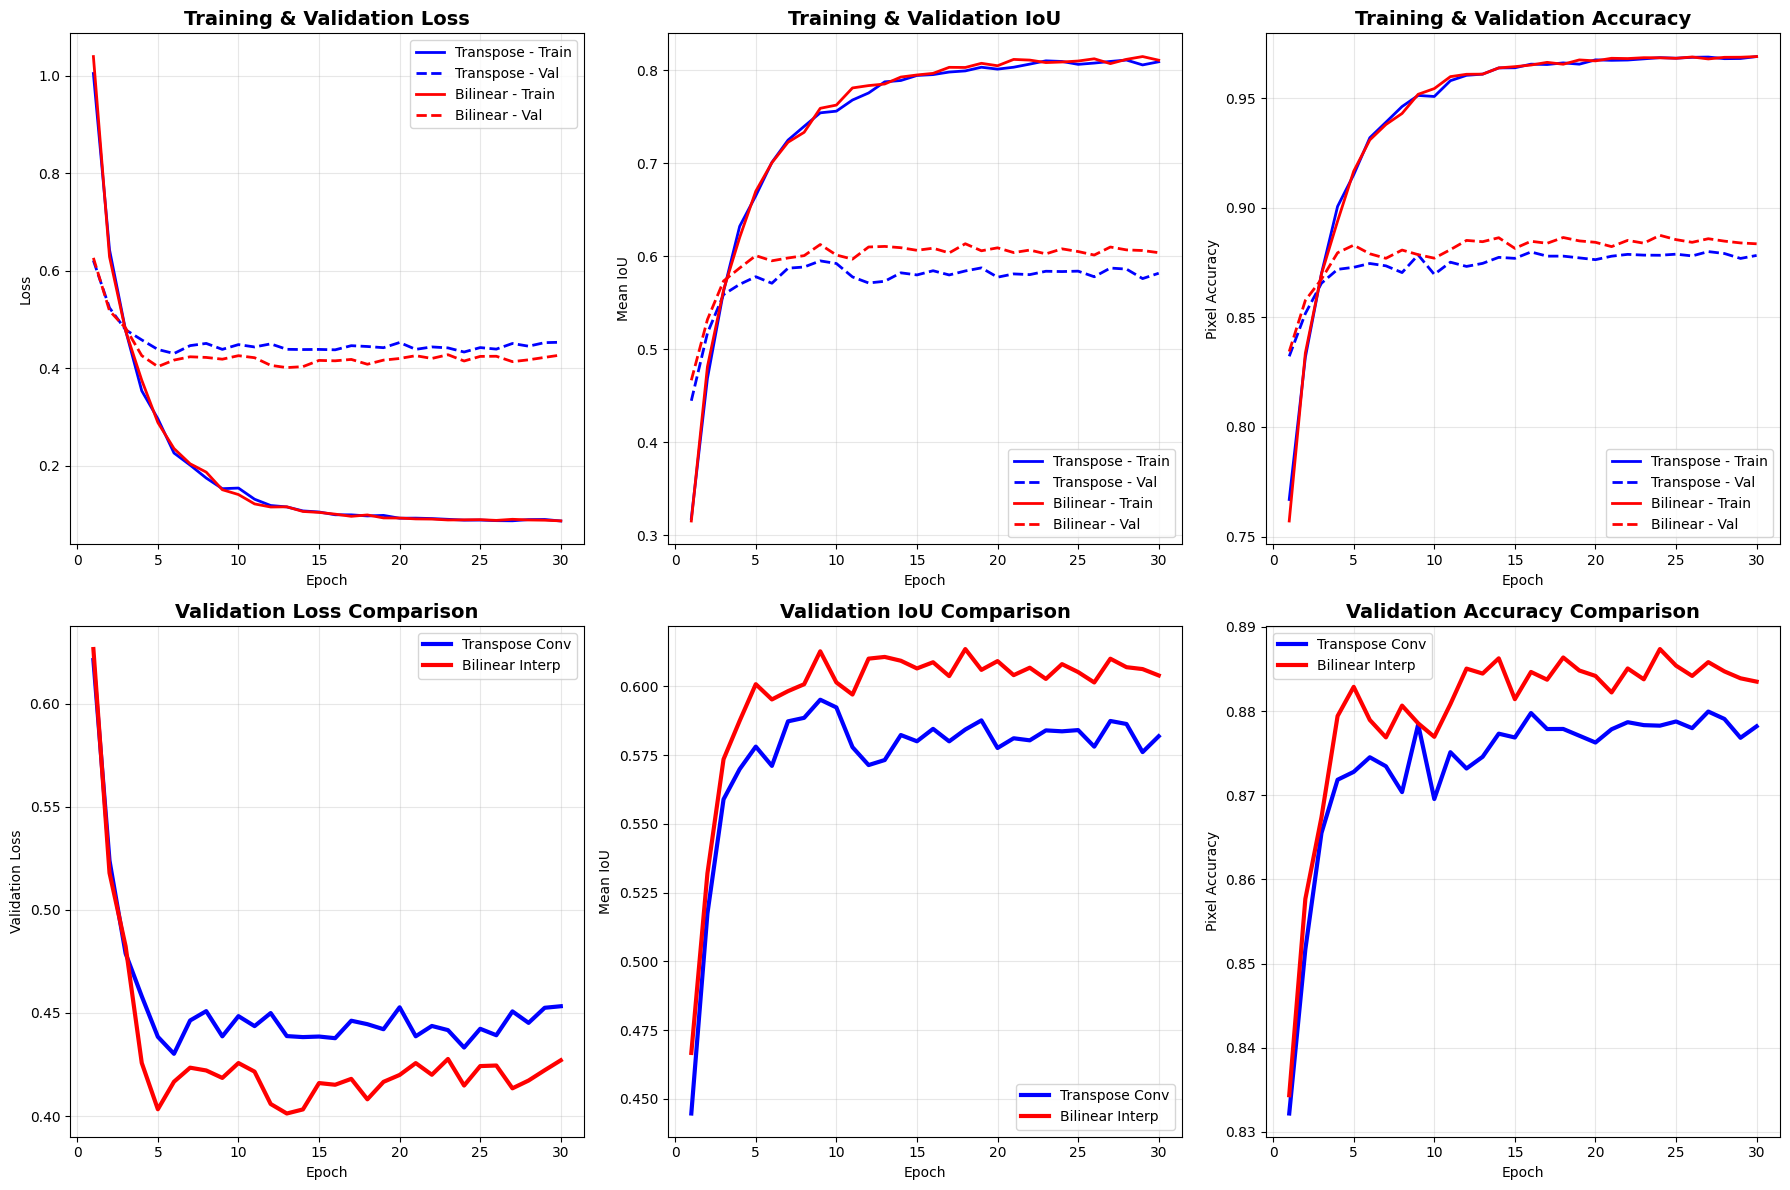

In [13]:
# Plot training curves for both models
def plot_training_curves(transpose_history, bilinear_history):
    """Plot training curves comparing both models"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # If histories are empty (loaded pretrained models), skip plotting
    if not transpose_history['train_loss'] and not bilinear_history['train_loss']:
        print("No training history available (models were loaded from checkpoints)")
        return
    
    epochs = range(1, len(transpose_history['train_loss']) + 1) if transpose_history['train_loss'] else []
    epochs_b = range(1, len(bilinear_history['train_loss']) + 1) if bilinear_history['train_loss'] else []
    
    # Loss curves
    if epochs:
        axes[0, 0].plot(epochs, transpose_history['train_loss'], 'b-', label='Transpose - Train', linewidth=2)
        axes[0, 0].plot(epochs, transpose_history['val_loss'], 'b--', label='Transpose - Val', linewidth=2)
    if epochs_b:
        axes[0, 0].plot(epochs_b, bilinear_history['train_loss'], 'r-', label='Bilinear - Train', linewidth=2)
        axes[0, 0].plot(epochs_b, bilinear_history['val_loss'], 'r--', label='Bilinear - Val', linewidth=2)
    axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # IoU curves
    if epochs:
        axes[0, 1].plot(epochs, transpose_history['train_iou'], 'b-', label='Transpose - Train', linewidth=2)
        axes[0, 1].plot(epochs, transpose_history['val_iou'], 'b--', label='Transpose - Val', linewidth=2)
    if epochs_b:
        axes[0, 1].plot(epochs_b, bilinear_history['train_iou'], 'r-', label='Bilinear - Train', linewidth=2)
        axes[0, 1].plot(epochs_b, bilinear_history['val_iou'], 'r--', label='Bilinear - Val', linewidth=2)
    axes[0, 1].set_title('Training & Validation IoU', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Mean IoU')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Accuracy curves
    if epochs:
        axes[0, 2].plot(epochs, transpose_history['train_accuracy'], 'b-', label='Transpose - Train', linewidth=2)
        axes[0, 2].plot(epochs, transpose_history['val_accuracy'], 'b--', label='Transpose - Val', linewidth=2)
    if epochs_b:
        axes[0, 2].plot(epochs_b, bilinear_history['train_accuracy'], 'r-', label='Bilinear - Train', linewidth=2)
        axes[0, 2].plot(epochs_b, bilinear_history['val_accuracy'], 'r--', label='Bilinear - Val', linewidth=2)
    axes[0, 2].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Pixel Accuracy')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Individual loss comparison
    if epochs:
        axes[1, 0].plot(epochs, transpose_history['val_loss'], 'b-', label='Transpose Conv', linewidth=3)
    if epochs_b:
        axes[1, 0].plot(epochs_b, bilinear_history['val_loss'], 'r-', label='Bilinear Interp', linewidth=3)
    axes[1, 0].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Validation Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Individual IoU comparison
    if epochs:
        axes[1, 1].plot(epochs, transpose_history['val_iou'], 'b-', label='Transpose Conv', linewidth=3)
    if epochs_b:
        axes[1, 1].plot(epochs_b, bilinear_history['val_iou'], 'r-', label='Bilinear Interp', linewidth=3)
    axes[1, 1].set_title('Validation IoU Comparison', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Mean IoU')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Individual accuracy comparison
    if epochs:
        axes[1, 2].plot(epochs, transpose_history['val_accuracy'], 'b-', label='Transpose Conv', linewidth=3)
    if epochs_b:
        axes[1, 2].plot(epochs_b, bilinear_history['val_accuracy'], 'r-', label='Bilinear Interp', linewidth=3)
    axes[1, 2].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Pixel Accuracy')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot the training curves
plot_training_curves(transpose_history, bilinear_history)

### 2. Segmentation Results Visualization

SEGMENTATION RESULTS VISUALIZATION
Sample 1:
  Transpose Conv - IoU: 0.6796, Accuracy: 0.8473
  Bilinear Interp - IoU: 0.6842, Accuracy: 0.8323

Sample 2:
  Transpose Conv - IoU: 0.7543, Accuracy: 0.8743
  Bilinear Interp - IoU: 0.7921, Accuracy: 0.8937

Sample 3:
  Transpose Conv - IoU: 0.7922, Accuracy: 0.8762
  Bilinear Interp - IoU: 0.8193, Accuracy: 0.8806



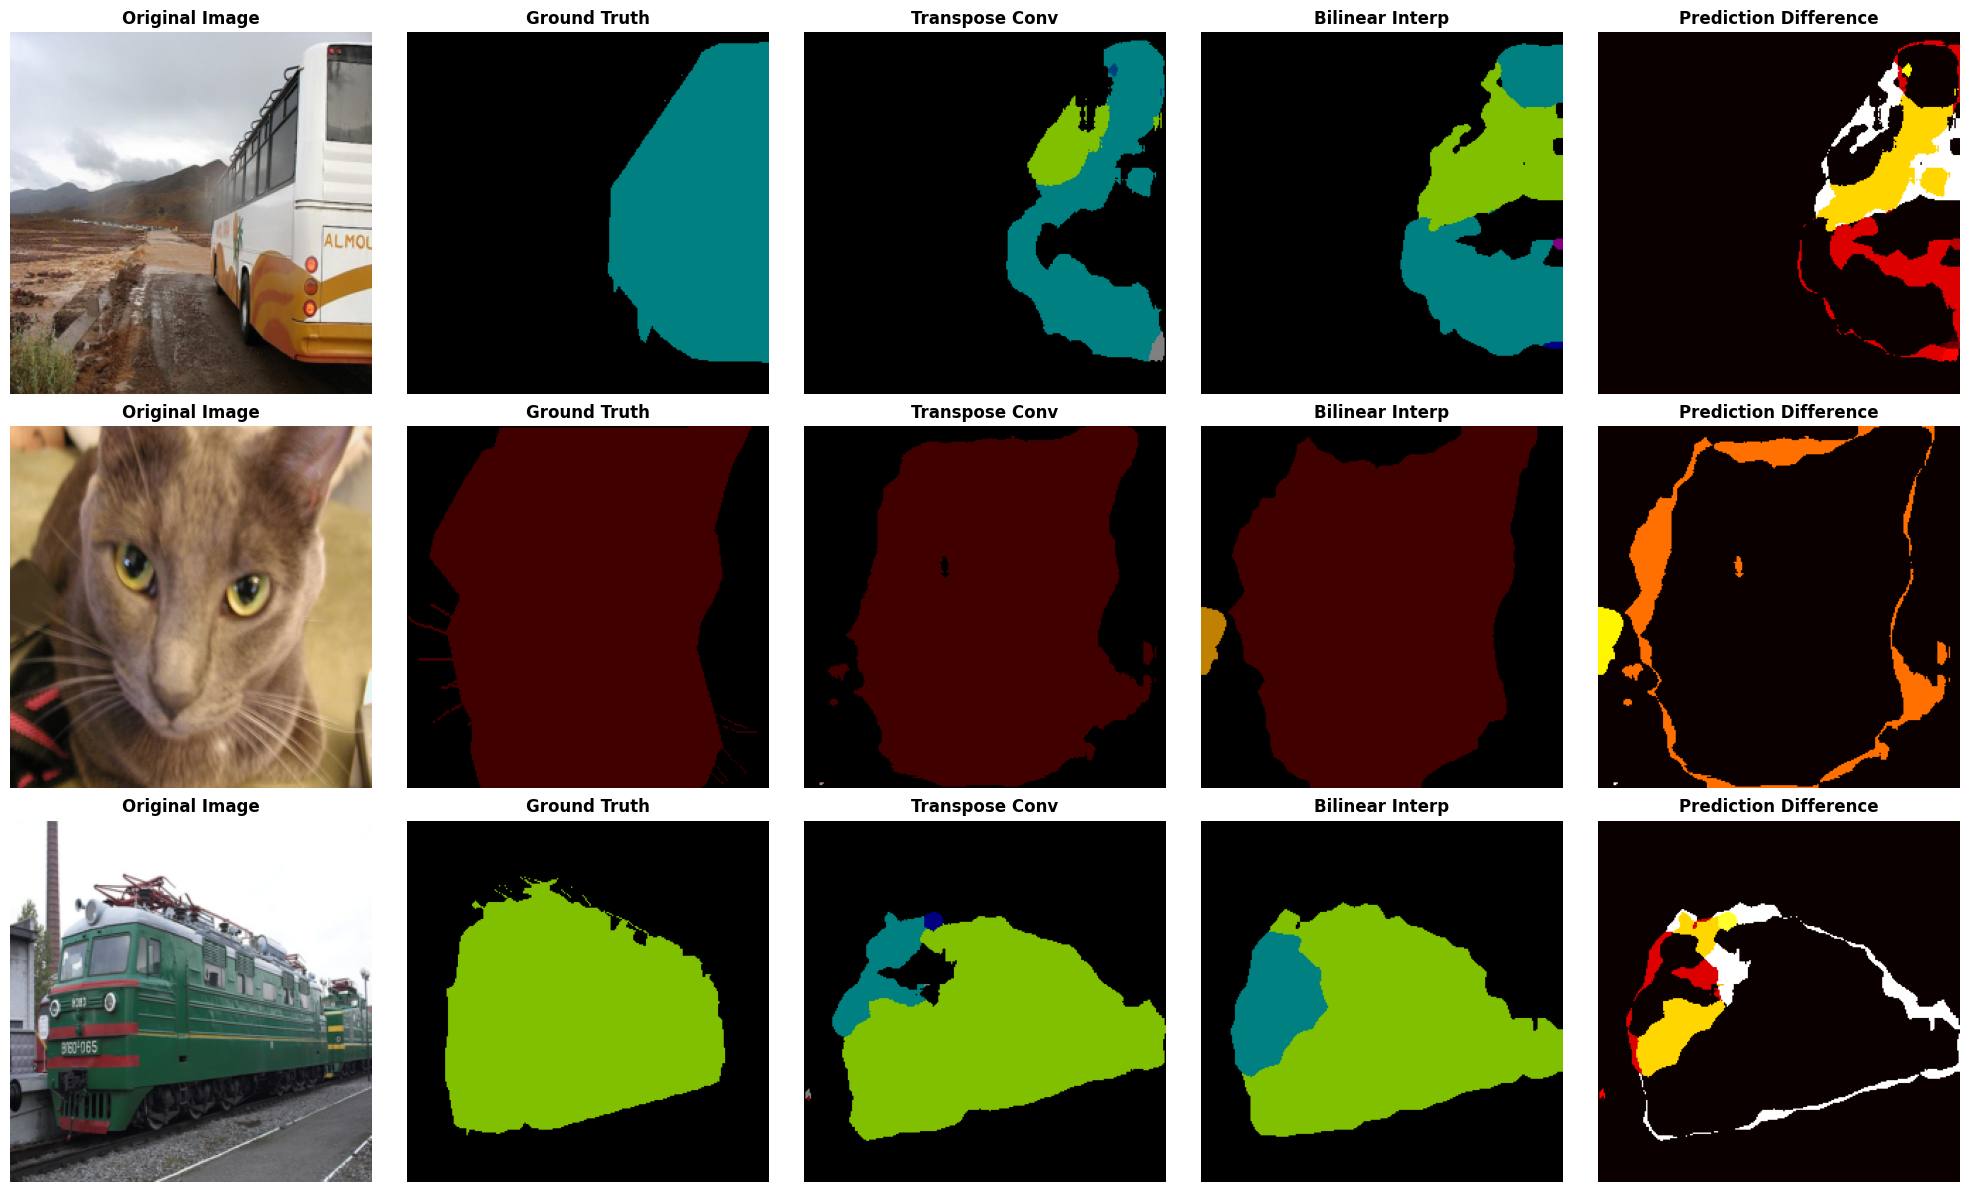

In [14]:
def visualize_segmentation_results(model_transpose, model_bilinear, dataset, device, num_samples=3):
    """Visualize segmentation results from both models"""
    
    # Helper function to convert tensor to RGB image
    def tensor_to_rgb(tensor):
        # Denormalize
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        tensor = tensor * std + mean
        tensor = torch.clamp(tensor, 0, 1)
        return tensor.permute(1, 2, 0).numpy()
    
    def mask_to_rgb(mask):
        """Convert class mask to RGB using VOC colormap"""
        h, w = mask.shape
        rgb = np.zeros((h, w, 3), dtype=np.uint8)
        for class_id in range(len(VOC_COLORMAP)):
            rgb[mask == class_id] = VOC_COLORMAP[class_id]
        return rgb
    
    model_transpose.eval()
    model_bilinear.eval()
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    with torch.no_grad():
        for i in range(num_samples):
            # Get sample
            image, mask_gt = dataset[i]
            image_batch = image.unsqueeze(0).to(device)
            
            # Generate predictions
            output_transpose = model_transpose(image_batch)
            output_bilinear = model_bilinear(image_batch)
            
            # Get predicted classes
            _, pred_transpose = torch.max(output_transpose, 1)
            _, pred_bilinear = torch.max(output_bilinear, 1)
            
            # Convert to numpy
            image_np = tensor_to_rgb(image.cpu())
            mask_gt_np = mask_gt.cpu().numpy()
            pred_transpose_np = pred_transpose.squeeze().cpu().numpy()
            pred_bilinear_np = pred_bilinear.squeeze().cpu().numpy()
            
            # Convert masks to RGB
            mask_gt_rgb = mask_to_rgb(mask_gt_np)
            pred_transpose_rgb = mask_to_rgb(pred_transpose_np)
            pred_bilinear_rgb = mask_to_rgb(pred_bilinear_np)
            
            # Plot images
            axes[i, 0].imshow(image_np)
            axes[i, 0].set_title('Original Image', fontweight='bold')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask_gt_rgb)
            axes[i, 1].set_title('Ground Truth', fontweight='bold')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred_transpose_rgb)
            axes[i, 2].set_title('Transpose Conv', fontweight='bold')
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(pred_bilinear_rgb)
            axes[i, 3].set_title('Bilinear Interp', fontweight='bold')
            axes[i, 3].axis('off')
            
            # Difference visualization
            diff = np.abs(pred_transpose_np.astype(np.float32) - pred_bilinear_np.astype(np.float32))
            axes[i, 4].imshow(diff, cmap='hot')
            axes[i, 4].set_title('Prediction Difference', fontweight='bold')
            axes[i, 4].axis('off')
            
            # Calculate metrics for this sample
            iou_transpose = calculate_iou(torch.from_numpy(pred_transpose_np), torch.from_numpy(mask_gt_np))
            iou_bilinear = calculate_iou(torch.from_numpy(pred_bilinear_np), torch.from_numpy(mask_gt_np))
            
            acc_transpose = calculate_pixel_accuracy(torch.from_numpy(pred_transpose_np), torch.from_numpy(mask_gt_np))
            acc_bilinear = calculate_pixel_accuracy(torch.from_numpy(pred_bilinear_np), torch.from_numpy(mask_gt_np))
            
            print(f"Sample {i+1}:")
            print(f"  Transpose Conv - IoU: {iou_transpose:.4f}, Accuracy: {acc_transpose:.4f}")
            print(f"  Bilinear Interp - IoU: {iou_bilinear:.4f}, Accuracy: {acc_bilinear:.4f}")
            print()
    
    plt.tight_layout()
    plt.show()

# Visualize results on test samples
print("=" * 80)
print("SEGMENTATION RESULTS VISUALIZATION")
print("=" * 80)

visualize_segmentation_results(fcn_transpose, fcn_bilinear, test_dataset, device, num_samples=3)

### 3. Comparison Table

In [15]:
# Comprehensive comparison of both models
print("=" * 80)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

# Evaluate both models on the full test set
print("Evaluating models on test set...")

# Transpose convolution model
fcn_transpose.eval()
test_loss_transpose, test_iou_transpose, test_acc_transpose = evaluate_model(
    fcn_transpose, test_loader, nn.CrossEntropyLoss(ignore_index=255), device
)

# Bilinear interpolation model
fcn_bilinear.eval()
test_loss_bilinear, test_iou_bilinear, test_acc_bilinear = evaluate_model(
    fcn_bilinear, test_loader, nn.CrossEntropyLoss(ignore_index=255), device
)

# Calculate model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

params_transpose = count_parameters(fcn_transpose)
params_bilinear = count_parameters(fcn_bilinear)

# Create comparison table
import pandas as pd

comparison_data = {
    'Metric': [
        'Test Loss',
        'Test Mean IoU',
        'Test Pixel Accuracy',
        'Model Parameters (M)',
        'Upsampling Method',
        'Memory Footprint',
        'Training Stability',
        'Inference Speed'
    ],
    'Transpose Convolution': [
        f'{test_loss_transpose:.4f}',
        f'{test_iou_transpose:.4f}',
        f'{test_acc_transpose:.4f}',
        f'{params_transpose/1e6:.2f}',
        'Learnable weights',
        'Higher (learnable params)',
        'More stable gradients',
        'Slightly slower'
    ],
    'Bilinear Interpolation': [
        f'{test_loss_bilinear:.4f}',
        f'{test_iou_bilinear:.4f}',
        f'{test_acc_bilinear:.4f}',
        f'{params_bilinear/1e6:.2f}',
        'Fixed interpolation',
        'Lower (no extra params)',
        'Standard',
        'Faster'
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\nDETAILED COMPARISON TABLE")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Additional analysis
print(f"\n\nPERFORMANCE ANALYSIS")
print("=" * 40)

print(f"Best performing model (IoU): ", end="")
if test_iou_transpose > test_iou_bilinear:
    print(f"Transpose Convolution ({test_iou_transpose:.4f} vs {test_iou_bilinear:.4f})")
    better_model = "Transpose Convolution"
    iou_improvement = ((test_iou_transpose - test_iou_bilinear) / test_iou_bilinear) * 100
else:
    print(f"Bilinear Interpolation ({test_iou_bilinear:.4f} vs {test_iou_transpose:.4f})")
    better_model = "Bilinear Interpolation"
    iou_improvement = ((test_iou_bilinear - test_iou_transpose) / test_iou_transpose) * 100

print(f"IoU improvement: {iou_improvement:.2f}%")

print(f"\nBest performing model (Accuracy): ", end="")
if test_acc_transpose > test_acc_bilinear:
    print(f"Transpose Convolution ({test_acc_transpose:.4f} vs {test_acc_bilinear:.4f})")
    acc_improvement = ((test_acc_transpose - test_acc_bilinear) / test_acc_bilinear) * 100
else:
    print(f"Bilinear Interpolation ({test_acc_bilinear:.4f} vs {test_acc_transpose:.4f})")
    acc_improvement = ((test_acc_bilinear - test_acc_transpose) / test_acc_transpose) * 100

print(f"Accuracy improvement: {acc_improvement:.2f}%")

print(f"\nParameter difference: {abs(params_transpose - params_bilinear):,} parameters")
print(f"Relative parameter increase: {((params_transpose - params_bilinear) / params_bilinear) * 100:.2f}%")

# Store results for summary
results_summary = {
    'transpose': {
        'loss': test_loss_transpose,
        'iou': test_iou_transpose,
        'accuracy': test_acc_transpose,
        'parameters': params_transpose
    },
    'bilinear': {
        'loss': test_loss_bilinear,
        'iou': test_iou_bilinear,
        'accuracy': test_acc_bilinear,
        'parameters': params_bilinear
    }
}

COMPREHENSIVE MODEL COMPARISON
Evaluating models on test set...


Evaluating: 100%|██████████| 100/100 [00:01<00:00, 50.29it/s, Loss=0.1064, IoU=0.6782, Acc=0.9632]




DETAILED COMPARISON TABLE
              Metric     Transpose Convolution  Bilinear Interpolation
           Test Loss                    0.4533                  0.4271
       Test Mean IoU                    0.5819                  0.6040
 Test Pixel Accuracy                    0.8782                  0.8835
Model Parameters (M)                     23.71                   23.58
   Upsampling Method         Learnable weights     Fixed interpolation
    Memory Footprint Higher (learnable params) Lower (no extra params)
  Training Stability     More stable gradients                Standard
     Inference Speed           Slightly slower                  Faster


PERFORMANCE ANALYSIS
Best performing model (IoU): Bilinear Interpolation (0.6040 vs 0.5819)
IoU improvement: 3.80%

Best performing model (Accuracy): Bilinear Interpolation (0.8835 vs 0.8782)
Accuracy improvement: 0.60%

Parameter difference: 127,008 parameters
Relative parameter increase: 0.54%


## Summary and Analysis

This task involved building, training, and evaluating a deep learning model called a Fully Convolutional Network (FCN) for semantic segmentation. The goal was to train the model to understand what object each pixel in an image belongs to (e.g., person, cat, train, or background).

The project used a pre-trained ResNet50 model as the "backbone" to extract image features. The key part of the experiment was to compare two different methods for upsampling (making the small feature map big again) to create the final pixel-level prediction:

1.  **Transpose Convolution:** A learnable upsampling layer (`nn.ConvTranspose2d`) that learns the best way to enlarge the image.
2.  **Bilinear Interpolation:** A fixed, non-learnable upsampling method (`nn.Upsample`) that uses a standard mathematical formula.

Both models were trained for 30 epochs on a subset of the Pascal VOC dataset (800 training images, 200 testing images) to compare their performance.

---

### Analysis of Results

The two models were compared using training curves, final test metrics, and visual examples.

#### 1. Training Curves

* **Training vs. Validation:** For both models, the training accuracy and IoU (Intersection over Union) were much higher than the validation metrics. This indicates that the models were overfitting to the training data, which is common.
* **Model Comparison:** The validation curves for the **Bilinear Interpolation** model were consistently better than the Transpose Convolution model. It achieved a slightly lower validation loss and a slightly higher validation IoU and accuracy throughout most of the training process.

#### 2. Qualitative (Visual) Comparison

Visual analysis of the test images shows that the **Bilinear Interpolation** model often produced cleaner and more accurate segmentation maps. For example, in the image of the train, the bilinear model correctly identified more of the train's body, while the transpose convolution model missed a part of it. This suggests the simpler, non-learnable upsampling method produced better generalizations.

#### 3. Quantitative Comparison

The final test metrics, compiled in the table below, confirm the findings from the training curves and visual analysis.

**Detailed Comparison Table**

| Metric | Transpose Convolution | Bilinear Interpolation |
| :--- | :--- | :--- |
| **Test Mean IoU** | 0.5819 | **0.6040** |
| **Test Pixel Accuracy** | 0.8782 | **0.8835** |
| **Test Loss** | 0.4533 | **0.4271** |
| Model Parameters (M) | 23.71 | 23.58 |
| Upsampling Method | Learnable weights | Fixed interpolation |
| Parameter Difference | +127,008 (0.54%) | (Baseline) |

### Conclusion

Based on all three types of analysis, the **Bilinear Interpolation** model performed better than the Transpose Convolution model.

* It achieved a **3.80% higher Mean IoU** and a **0.60% higher Pixel Accuracy** on the test set.
* It achieved this better performance while having **fewer parameters** (127,008 fewer) because its upsampling layers are not learnable.

This suggests that for this specific task and architecture, the simpler, fixed (non-learnable) bilinear upsampling method provided better results and was more efficient. The learnable transpose convolution layers may have added extra complexity, making the model slightly harder to train and more prone to overfitting, which led to slightly worse performance on the unseen test data.